In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.patches as patches
import glob

import matplotlib.colors as mcolors

from netCDF4 import Dataset
from scipy import stats

from wrf import getvar

from matplotlib.animation import FuncAnimation


## estimate of pressure levels from the hybrid coordinate:
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100

### First, load the lats, lons, and levs used for plotting later.

In [38]:
### Plot the height vs. time sections of potential temperature
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon561x721_ILdeforested/wrfout_d01_2015-11-01_00:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    lats=ds1['XLAT'][0,:,0]
    lons=ds1['XLONG'][0,0,:]
    lu1=ds1['LU_INDEX'][0,:,:]
    pb = ds1['PB'][0,:,:,:]

file0 = path+'Amazon_NoahMP/energyflux_d01_2015-11-01_00:00:00'
with xarray.open_dataset(file0,decode_times=False,
                         mask_and_scale='True') as ds0:
    lu0=ds0['LU_INDEX'][0,:,:]

# 1.Cloud fraction

## 1.1 mean of all time samples

In [44]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
with xarray.open_dataset(path+'post_processing/Amazon561x721/Cloudfrac.obs.Noah.day1_29.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/Cloudfrac.ILgrassland.Noah.day1_29.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
                         print('ok')
    
cld0_ave=ds0['cloudfrac'][:5*24,:,:].mean('TIME')
cld1_ave=ds1['cloudfrac'][:5*24,:,:].mean('TIME')

ok
ok


## Show the mean state of the clouds

<ipython-input-42-75806e846826>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img=axes[ii].pcolormesh(lons,lats,cld1_ave[ii,:,:],cmap='Blues_r',vmin=0,vmax=1)


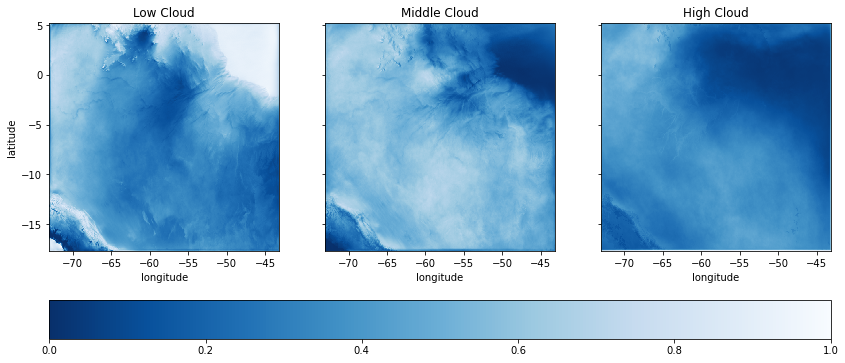

In [42]:
fig,axes = plt.subplots(1,3,figsize=(14,6),sharex=True,sharey=True)

titles=['Low Cloud','Middle Cloud','High Cloud']
for ii in range(3):
    img=axes[ii].pcolormesh(lons,lats,cld1_ave[ii,:,:],cmap='Blues_r',vmin=0,vmax=1)
    axes[ii].set_title(titles[ii])
    axes[ii].set_xlabel('longitude')
axes[0].set_ylabel('latitude')
fig.colorbar(img,ax=axes[:],orientation='horizontal')

## Changes in clouds

<ipython-input-45-55578757e80c>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img=axes[ii].pcolormesh(lons,lats,dif_cloud[ii,:,:],cmap='RdBu_r',vmin=-0.2,vmax=0.2)
<ipython-input-45-55578757e80c>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img=axes[ii].pcolormesh(lons,lats,dif_cloud[ii,:,:],cmap='RdBu_r',vmin=-0.2,vmax=0.2)
<ipython-input-45-55578757e80c>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is de

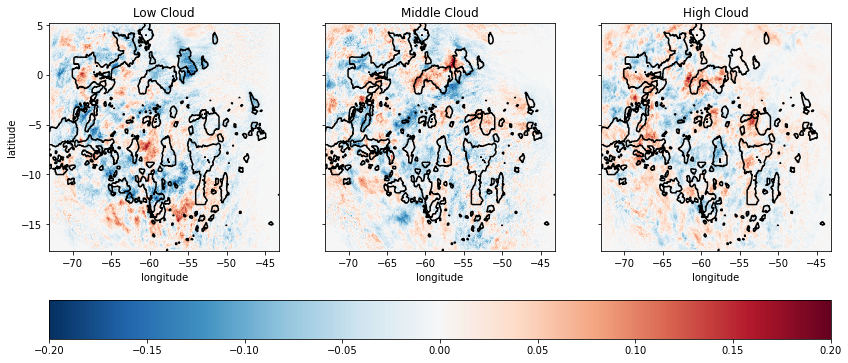

In [45]:
dif_cloud = cld1_ave - cld0_ave

fig,axes = plt.subplots(1,3,figsize=(14,6),sharex=True,sharey=True)

titles=['Low Cloud','Middle Cloud','High Cloud']
for ii in range(3):
    img=axes[ii].pcolormesh(lons,lats,dif_cloud[ii,:,:],cmap='RdBu_r',vmin=-0.2,vmax=0.2)
    axes[ii].contour(lons,lats,lu1-lu0,colors='k',levels=[0])
    axes[ii].set_title(titles[ii])
    axes[ii].set_xlabel('longitude')
axes[0].set_ylabel('latitude')

fig.colorbar(img,ax=axes[:],orientation='horizontal')

## Diurnal cycle

In [53]:
dif = ds1[varname[ii]] - ds0[varname[ii]]
dif_lu = lu1-lu0
dif_forests = dif.where(dif_lu>0)
diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
diurnal_west = dif_forests[0,100:,:200].mean(('south_north','west_east'))
#plt.contourf(dif_forests)


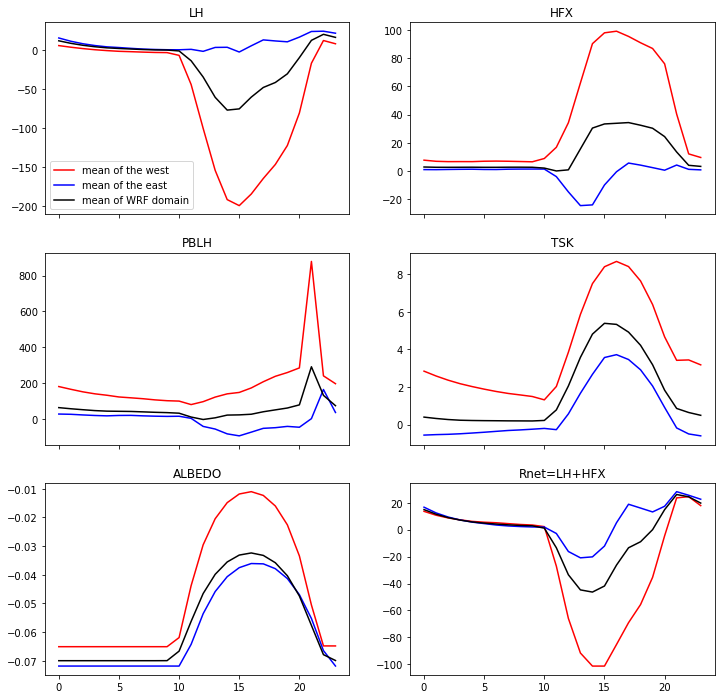

In [70]:
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True)
axes = axes.ravel()  
varname = ['LH','HFX','PBLH','TSK','ALBEDO','Rnet=LH+HFX']
for ii in range(5):
    dif = ds1[varname[ii]] - ds0[varname[ii]]
    dif_lu = lu1-lu0
    dif_forests = dif.where(dif_lu>0)
    diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
    diurnal_west = dif_forests[:,100:,:200].mean(('south_north','west_east'))
    diurnal_all = dif_forests.mean(('south_north','west_east'))

    
    axes[ii].plot(range(24),diurnal_north,'-r',label='mean of the west')
    axes[ii].plot(range(24),diurnal_west,'-b',label='mean of the east')
    axes[ii].plot(range(24),diurnal_all,'-k',label='mean of WRF domain')

    axes[ii].set_title(varname[ii])
    
axes[0].legend()
   
## plot Rnet
dif_Rnet = ds1['LH'] + ds1['HFX'] - (ds0['LH'] + ds0['HFX'])
dif_forests = dif_Rnet.where(dif_lu>0)
diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
diurnal_west = dif_forests[:,100:,:200].mean(('south_north','west_east'))
diurnal_all = dif_forests.mean(('south_north','west_east'))
axes[5].plot(range(24),diurnal_north,'-r')
axes[5].plot(range(24),diurnal_west,'-b')
axes[5].plot(range(24),diurnal_all,'-k')
axes[5].set_title(varname[5])

